Using base_dir = /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/results/20251209_partial_U_lambda_series/T_0.5
Found 9 CSV files
Saving analysis to /nfs/roberts/project/pi_co54/bh692/MD_Simulation_CUDA/results/20251209_partial_U_lambda_series/T_0.5/data_analysis
Summary of per-lambda statistics:


,lambda_deform,partial_U_mean,partial_U_sem,Ly_mean,n_samples,csv_path
0,0.0,-26.016863,10.419240,106.666667,395,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...
1,0.1,-33.169909,11.476078,105.078607,372,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...
2,0.2,-20.262979,10.660638,103.514191,395,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...
3,0.3,-20.533588,12.070093,101.973065,366,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...
4,0.4,-0.509698,11.784431,100.454884,366,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...
5,0.5,-20.341930,10.644332,98.959306,387,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...
6,0.6,1.379877,10.667803,97.485993,388,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...
7,0.7,-18.156865,12.224734,96.034616,361,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...
8,0.8,-13.765075,10.975461,94.604847,386,/nfs/roberts/project/pi_co54/bh692/MD_Simulati...


Linear fit: delta F = 2 * gamma * delta Ly + intercept
gamma = 0.502708 ± 0.042858, intercept = -1.62639


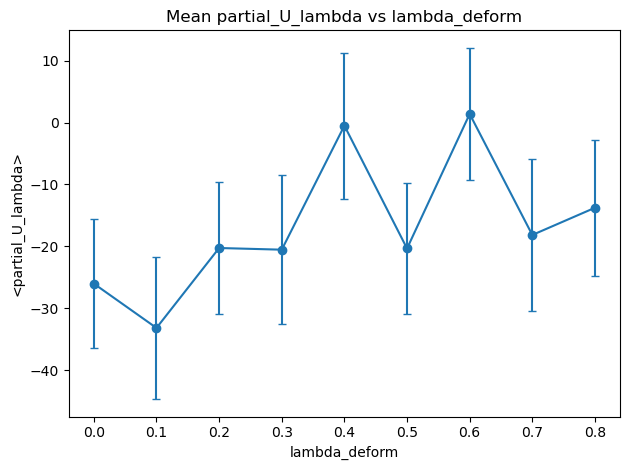

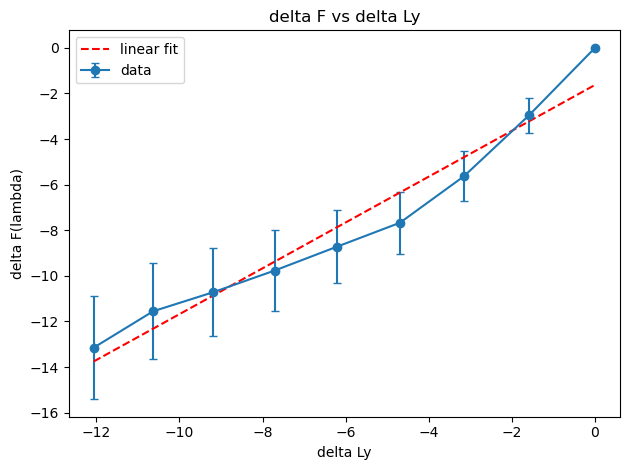

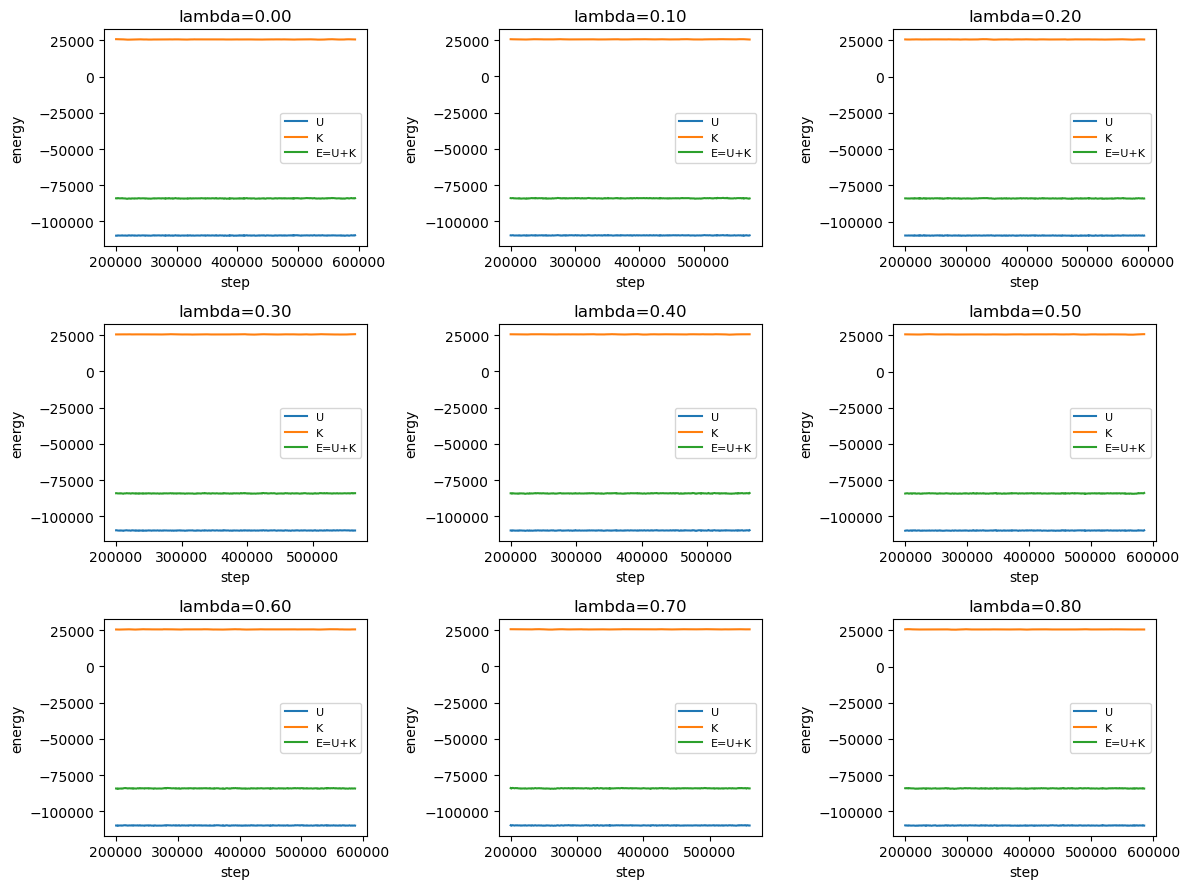

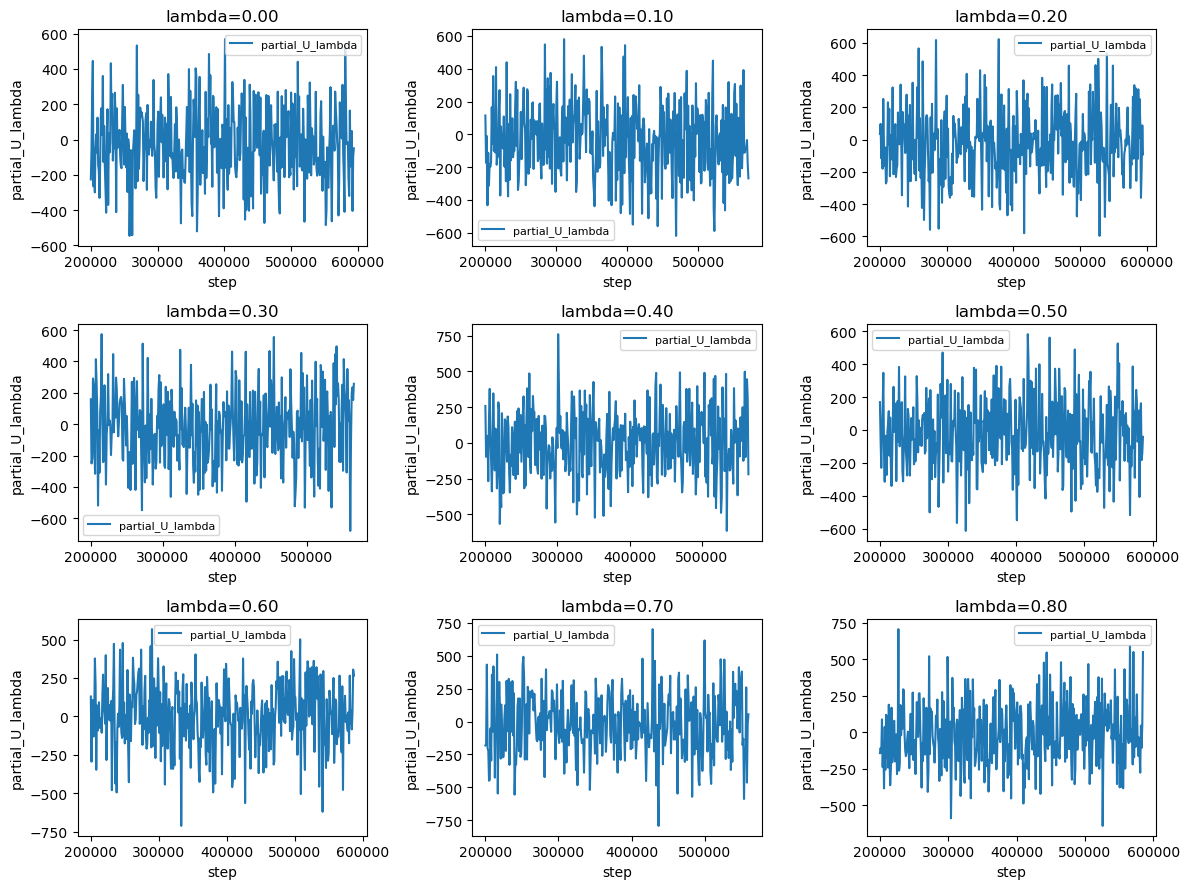

In [8]:
# Analysis of partial_U_lambda series

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Locate base directory containing the lambda subfolders (robust to where Jupyter is started)
target_rel = Path("results/20251209_partial_U_lambda_series/T_0.5")
cwd = Path.cwd()
for parent in [cwd] + list(cwd.parents):
    candidate = parent / target_rel
    if candidate.exists():
        base_dir = candidate
        break
else:
    raise RuntimeError(f"Could not find base_dir for {target_rel} starting from {cwd}")

csv_paths = sorted(base_dir.glob("*/sample_csv/U_K_tot_log.csv"))
print(f"Using base_dir = {base_dir}")
print(f"Found {len(csv_paths)} CSV files")

output_dir = base_dir / "data_analysis"
output_dir.mkdir(exist_ok=True)
print(f"Saving analysis to {output_dir}")

records = []
timeseries = []
for csv_path in csv_paths:
    # Each line is: name, value, name, value, ...
    # Read as a generic CSV with no header
    df = pd.read_csv(csv_path, header=None, skipinitialspace=True)

    # Column indices for values in the custom format:
    # 0: U_tot (name), 1: U_tot value
    # 2: K_tot (name), 3: K_tot value
    # 4: partial_U_lambda (name), 5: partial_U_lambda value
    # 6: epsilon_deform (name), 7: epsilon_deform value
    # 8: lambda_deform (name), 9: lambda_deform value
    # 10: Lx (name), 11: Lx value
    # 12: Ly (name), 13: Ly value
    # 14: step (name), 15: step value

    # Filter by step >= 100000
    steps = df.iloc[:, 15].astype(float)
    mask = steps >= 200000
    if not mask.any():
        print(f"Skipping {csv_path} (no data with step >= 100000)")
        continue

    df_sel = df.loc[mask]
    step = df_sel.iloc[:, 15].astype(float).to_numpy()
    u_tot = df_sel.iloc[:, 1].astype(float).to_numpy()
    k_tot = df_sel.iloc[:, 3].astype(float).to_numpy()
    partial_u = df_sel.iloc[:, 5].astype(float).to_numpy()
    ly = df_sel.iloc[:, 13].astype(float).to_numpy()
    lam = df_sel.iloc[:, 9].astype(float).to_numpy()

    lam_mean = lam.mean()
    partial_mean = partial_u.mean()
    partial_std = partial_u.std(ddof=1)
    n = len(partial_u)
    partial_sem = partial_std / np.sqrt(n) if n > 0 else np.nan
    ly_mean = ly.mean()

    records.append({
        "lambda_deform": lam_mean,
        "partial_U_mean": partial_mean,
        "partial_U_sem": partial_sem,
        "Ly_mean": ly_mean,
        "n_samples": n,
        "csv_path": str(csv_path),
    })

    timeseries.append({
        "lambda_deform": lam_mean,
        "step": step,
        "U_tot": u_tot,
        "K_tot": k_tot,
        "partial_U_lambda": partial_u,
    })

if not csv_paths:
    raise RuntimeError(f"No CSV files found under {base_dir}. Check paths and working directory.")
if not records:
    raise RuntimeError("No usable data found (all files filtered out by step >= 100000)")

summary = pd.DataFrame(records).sort_values("lambda_deform").reset_index(drop=True)
print("Summary of per-lambda statistics:")
display(summary)
summary.to_csv(output_dir / "summary_partial_U_lambda.csv", index=False)

lam = summary["lambda_deform"].to_numpy()
partial_mean = summary["partial_U_mean"].to_numpy()
partial_sem = summary["partial_U_sem"].to_numpy()
ly_mean = summary["Ly_mean"].to_numpy()
delta_ly = ly_mean - ly_mean[0]  # reference at smallest lambda (typically lambda=0)

# --- Fig 1: <partial_U_lambda> vs lambda_deform ---
fig1, ax1 = plt.subplots()
ax1.errorbar(lam, partial_mean, yerr=partial_sem, fmt="o-", capsize=3)
ax1.set_xlabel("lambda_deform")
ax1.set_ylabel("<partial_U_lambda>")
ax1.set_title("Mean partial_U_lambda vs lambda_deform")
fig1.tight_layout()
fig1.savefig(output_dir / "fig1_partialU_vs_lambda.png", dpi=300)

# --- Delta F(lambda) via trapezoidal integration ---
# delta F(lambda_i) = integral_{lambda_0}^{lambda_i} <partial_U_lambda> d lambda
dlam = np.diff(lam)
segment_contrib = 0.5 * dlam * (partial_mean[:-1] + partial_mean[1:])
delta_f = np.zeros_like(lam)
delta_f[1:] = np.cumsum(segment_contrib)

# Error propagation for delta F: assume independent errors on each mean
var = partial_sem ** 2
segment_var = (0.5 * dlam) ** 2 * (var[:-1] + var[1:])
delta_f_err = np.zeros_like(lam)
delta_f_err[1:] = np.sqrt(np.cumsum(segment_var))

# --- Linear regression: delta F vs delta Ly ---
mask_fit = np.isfinite(delta_ly) & np.isfinite(delta_f)
coeffs, cov = np.polyfit(delta_ly[mask_fit], delta_f[mask_fit], 1, cov=True)
slope, intercept = coeffs
slope_err = np.sqrt(cov[0, 0])
gamma = slope / 2.0
gamma_err = slope_err / 2.0
print("Linear fit: delta F = 2 * gamma * delta Ly + intercept")
print(f"gamma = {gamma:.6g} ± {gamma_err:.6g}, intercept = {intercept:.6g}")
fit_df = pd.DataFrame({
    "delta_Ly": delta_ly[mask_fit],
    "delta_F": delta_f[mask_fit],
    "delta_F_err": delta_f_err[mask_fit],
    "delta_F_fit": slope * delta_ly[mask_fit] + intercept,
})
fit_df.to_csv(output_dir / "deltaF_vs_deltaLy_fit.csv", index=False)
gamma_df = pd.DataFrame({
    "gamma": [gamma],
    "gamma_err": [gamma_err],
    "intercept": [intercept],
})
gamma_df.to_csv(output_dir / "gamma_fit_params.csv", index=False)
x_fit = np.linspace(delta_ly.min(), delta_ly.max(), 100)
y_fit = slope * x_fit + intercept

# --- Fig 2: delta F vs delta Ly ---
fig2, ax2 = plt.subplots()
ax2.errorbar(delta_ly, delta_f, yerr=delta_f_err, fmt="o-", capsize=3, label="data")
ax2.plot(x_fit, y_fit, "r--", label="linear fit")
ax2.set_xlabel("delta Ly")
ax2.set_ylabel("delta F(lambda)")
ax2.set_title("delta F vs delta Ly")
ax2.legend()
fig2.tight_layout()
fig2.savefig(output_dir / "fig2_deltaF_vs_deltaLy.png", dpi=300)

# --- Fig 3: U, K, E vs step for each lambda ---
n = len(timeseries)
ncols = 3
nrows = int(np.ceil(n / ncols))
fig3, axes3 = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=False, sharey=False)
axes3 = np.atleast_1d(axes3).ravel()
for i, ts in enumerate(timeseries):
    ax = axes3[i]
    step = ts["step"]
    u_tot = ts["U_tot"]
    k_tot = ts["K_tot"]
    e_tot = u_tot + k_tot
    lam_val = ts["lambda_deform"]
    ax.plot(step, u_tot, label="U")
    ax.plot(step, k_tot, label="K")
    ax.plot(step, e_tot, label="E=U+K")
    ax.set_title(f"lambda={lam_val:.2f}")
    ax.set_xlabel("step")
    ax.set_ylabel("energy")
    ax.legend(fontsize=8)

for ax in axes3[len(timeseries):]:
    ax.axis("off")

fig3.tight_layout()
fig3.savefig(output_dir / "fig3_U_K_E_vs_step.png", dpi=300)

# --- Fig 4: partial_U_lambda vs step for each lambda ---
fig4, axes4 = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=False, sharey=False)
axes4 = np.atleast_1d(axes4).ravel()
for i, ts in enumerate(timeseries):
    ax = axes4[i]
    step = ts["step"]
    partial_u = ts["partial_U_lambda"]
    lam_val = ts["lambda_deform"]
    ax.plot(step, partial_u, label="partial_U_lambda")
    ax.set_title(f"lambda={lam_val:.2f}")
    ax.set_xlabel("step")
    ax.set_ylabel("partial_U_lambda")
    ax.legend(fontsize=8)

for ax in axes4[len(timeseries):]:
    ax.axis("off")

fig4.tight_layout()
fig4.savefig(output_dir / "fig4_partialU_vs_step.png", dpi=300)

plt.show()
